# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
titanic = pd.read_csv('../data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [5]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [6]:
grab_numeric(X_train)

,Age,Fare
298,NaN,30.5000
884,25.00,7.0500
247,24.00,14.5000
478,22.00,7.5208
305,0.92,151.5500
...,...,...
106,21.00,7.6500
270,NaN,31.0000
860,41.00,14.1083
435,14.00,120.0000


In [7]:
def grab_object(df):
    return df.select_dtypes(include=['object'])

In [8]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [9]:
GrabObject = FunctionTransformer(grab_object)

In [10]:
GrabNumeric.fit(X_train)

FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)

In [11]:
# Pipe!
pipe = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])


That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [12]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric),
                              ('num_impute', SimpleImputer()),
                              ('ss', StandardScaler())])


subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


subpipe_ord = Pipeline(steps=[('ord_impute', SimpleImputer(strategy='most_frequent')),
                              ('ord', OrdinalEncoder())])




In [14]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X_train.columns),
    ('subpipe_cat', subpipe_cat, [0,5,7,8]),
    ('subpipe_ord', subpipe_ord, [1])
])


In [15]:
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,641,642,643,644,645,646,647,648,649,650
0,0.000000,-0.032568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.340110,-0.487331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.417034,-0.342854,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.570884,-0.478201,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-2.192453,2.314937,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,-0.647808,-0.475695,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
664,0.000000,-0.022872,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
665,0.890683,-0.350450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
666,-1.186280,1.703093,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.


logreg_model_pipe = Pipeline(steps=[
    ('ct',ct),
    ('logreg', LogisticRegression(random_state=42))
])

In [17]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [18]:
logreg_model_pipe.score(X_train, y_train)

0.8997005988023952

In [19]:
logreg_model_pipe.score(X_test, y_test)

0.820627802690583

In [20]:
cross_val_score(logreg_model_pipe, X_train, y_train)

array([0.79104478, 0.85074627, 0.79104478, 0.7593985 , 0.86466165])

## Bringing in Our Modeling Class from before

In [21]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [22]:
# Use the class withlogreg pipe


log_pipe = ModelWithCV(logreg_model_pipe, model_name = 'log_pipe', X=X_train, y=y_train)

<AxesSubplot:title={'center':'CV Results for `log_pipe` Model'}>

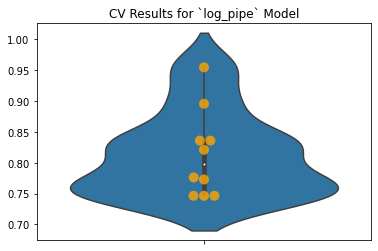

In [23]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

In [24]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.81303 ± 0.06655 accuracy
        


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [25]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', ct), ('rfc', rfc)])

In [26]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [27]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `forest_pipe` Model'}>

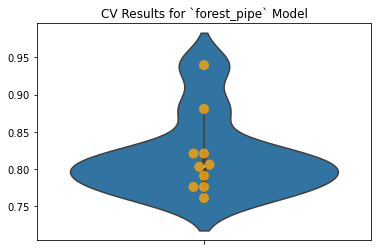

In [28]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

In [29]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.81753 ± 0.05148 accuracy
        


### Gradient Booster

In [30]:
# gbc!
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', GradientBoostingClassifier(random_state=42))])

In [31]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

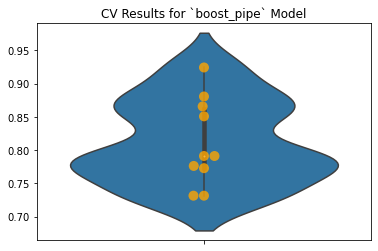

In [32]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [33]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.81149 ± 0.06197 accuracy
        


In [34]:
stc = StackingClassifier(estimators = [])

## Tuning and Cross-Validating

In [35]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', ct), ('rfc', rfc)])

In [36]:
# GridSearch?

params = {}

params['rfc__criterion'] = ['gini','entropy']
params['rfc__min_samples_leaf'] = [1,5,10]


In [37]:
params

{'rfc__criterion': ['gini', 'entropy'], 'rfc__min_samples_leaf': [1, 5, 10]}

In [38]:
gs = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10)

In [39]:
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embar

In [40]:
gs.cv_results_['mean_test_score']

array([0.81752601, 0.62125735, 0.62125735, 0.81451832, 0.62125735,
       0.62125735])

In [41]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [42]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1}

In [43]:
X_train.head(1)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,1,male,NaN,0,0,19988,30.5,C106,S


In [44]:
stc = StackingClassifier(estimators=[
    ('log_reg', LogisticRegression(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [45]:
stc_model_pipe = Pipeline([('ct',ct), ('stc', stc)])

In [46]:
stc_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=...
                                                              

In [47]:
stc_model_pipe.score(X_train,y_train)

0.9910179640718563

In [48]:
stc_model_pipe.score(X_test,y_test)

0.8161434977578476

In [49]:
stc

StackingClassifier(estimators=[('log_reg', LogisticRegression(random_state=42)),
                               ('rfc', RandomForestClassifier(random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(random_state=42))])

In [50]:
stc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=...
                                                              

In [51]:
params = {
    'stc__rfc__criterion' : ['gini','entropy'],
    'stc__rfc__min_samples_leaf': [1,5,10],
    'stc__log_reg__C':[.1,1,10],
    'ct__subpipe_num__num_impute__strategy':['mean','median']
}

In [52]:
params

{'stc__rfc__criterion': ['gini', 'entropy'],
 'stc__rfc__min_samples_leaf': [1, 5, 10],
 'stc__log_reg__C': [0.1, 1, 10],
 'ct__subpipe_num__num_impute__strategy': ['mean', 'median']}

In [53]:
gs2 = GridSearchCV(stc_model_pipe, params, cv=2)

In [54]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embark

In [55]:
gs2.best_params_

{'ct__subpipe_num__num_impute__strategy': 'mean',
 'stc__log_reg__C': 1,
 'stc__rfc__criterion': 'gini',
 'stc__rfc__min_samples_leaf': 1}

In [56]:
gs2.best_score_

0.8293413173652695

In [57]:
gs2.score(X_test,y_test)

0.8161434977578476

In [58]:
# Mean test score for each of six models

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [59]:
y_train.value_counts(normalize=True)

0    0.621257
1    0.378743
Name: Survived, dtype: float64

In [60]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [61]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [62]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [63]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [64]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [65]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts(normalize=True)

0    0.55614
1    0.44386
Name: Survived, dtype: float64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [66]:
# imbpipe!
imb_pipe = ImPipeline(steps=[('ct', ct),
                             ('sm', SMOTE(random_state=42)),
                             ('rfc', RandomForestClassifier(random_state=42))])

In [67]:
imb_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [68]:
imb_pipe.score(X_train,y_train)

0.9985029940119761

In [69]:
imb_pipe.score(X_test,y_test)

0.8251121076233184

### Gridsearching

In [70]:
# Seriously? Again?
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [71]:
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x00000204612A2160>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embar

In [72]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 9}

In [73]:
gs.best_score_

0.8295341474445952

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [74]:
final_model = gs.best_estimator_

C:\Users\jsidd\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


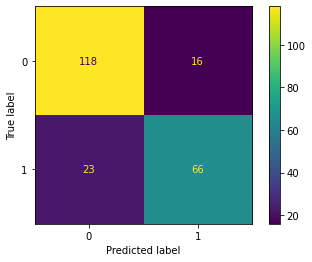

In [75]:
plot_confusion_matrix(final_model, X_test, y_test);

In [76]:
y_hat = final_model.predict(X_test)

In [77]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.74 

Our final model's precision on the test set is 0.8 

Our final model's f1-score on the test is 0.77.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [78]:
exos = sns.load_dataset('planets')

In [79]:
### Your work here






